In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
from metasense.epa import data as epa_data
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.cross_validation import train_test_split
from datetime import datetime
from IPython.display import HTML, Javascript, display
import GPy
sns.set_style('white')

/home/sharad/workspace/research/metasense/venv/local/lib/python2.7/site-packages/GPy/util/linalg.py:48: UserWarning: warning: caught this exception:/home/sharad/workspace/research/metasense/venv/local/lib/python2.7/site-packages/numpy/core/_dotblas.so: undefined symbol: dsyrk_
  warnings.warn("warning: caught this exception:" + str(e))


In [3]:
csvs = epa_data.load_data('../data')
data_map = {}
for csv, text in csvs.iteritems():
    data_map[csv] = epa_data.load_csv_from_string(text)

In [4]:
date_ids = []
date_frames = []
data_panel = {}
for date in data_map:
    reading_data = {}
    for reading_type in data_map[date]:
        reading_data[reading_type] = pd.DataFrame(data_map[date][reading_type])
    data_panel[date] = reading_data

In [5]:
D1 = pd.Panel4D(data_panel).convert_objects(convert_numeric=True).swapaxes(1, 2)

In [6]:
final_data_map = {}
for date in D1.keys():
    for time in D1[date].keys():
        year, month, day, hour = int(date[:4]), int(date[4:6]), int(date[6:8]), int(time)
        final_data_map[datetime(year, month, day, hour=time)] = D1[date][time]
data = pd.Panel(final_data_map).swapaxes(0, 1)

# Testing

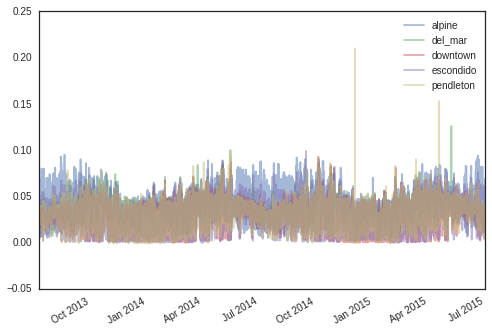

In [15]:
ozone_data = data['ozone'].dropna(thresh=15000, axis=1)
ozone_data = ozone_data.fillna(ozone_data.mean())
ozone_data.plot(alpha=0.5);
N, D = ozone_data.shape
X = []
y = []
for i in xrange(1, N):
    X.append(np.concatenate([[i], ozone_data[i-1:i].as_matrix().flatten()]))
    #X.append(ozone_data[i-1:i].as_matrix().flatten())
    y.append(ozone_data[i:i+1].as_matrix().flatten()) 
X, y = np.vstack(X), np.vstack(y)

In [16]:
kernel1 = GPy.kern.RBF(input_dim=1, lengthscale=100, active_dims=[0])
kernel2 = GPy.kern.RBF(input_dim=5, lengthscale=.1)#, active_dims=[1,2,3,4,5])
kernel = kernel1.prod(kernel2)
gp = GPy.models.SparseGPRegression(X[:1000, 1:], np.matrix(y[:, 3]).T[:1000], kernel2)
gp.optimize(messages=True)
#gp.plot();

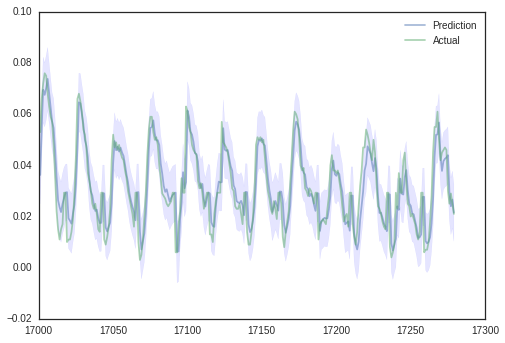

In [17]:
idx = (17000, 19000)
x = arange(1, N)
(y1, s), y2 = gp.predict(X[:, 1:]), y[:, 3]
std = sqrt(s)
high_bound = y1 + 2 * std
low_bound = y1 - 2 * std

plot(x[idx[0]:idx[1]], y1[idx[0]:idx[1]], alpha=0.5, label='Prediction')
plot(x[idx[0]:idx[1]], y2[idx[0]:idx[1]], alpha=0.5, label='Actual')
fill_between(x[idx[0]:idx[1]], 
             low_bound.ravel()[idx[0]:idx[1]], 
             high_bound.ravel()[idx[0]:idx[1]], 
             color='blue', alpha=0.1)
legend(loc='best');
#print y1, y2

In [14]:
X.shape

(17279, 5)